# GENERAL INFORMATION

# 1. Preparation

## 1.1 Importing libraries

In [1]:
import os
import sys
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
#import keras
from tensorflow import keras
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Input, Flatten,
                                     Dropout, UpSampling2D, GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from keras import backend as K
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
from sklearn.datasets import load_files
import platform
import shutil

from imblearn.over_sampling import SMOTE
from PIL import Image

2023-09-05 15:17:28.225130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1.2 GPU and System INFO

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

/bin/bash: /home/chloe/miniconda3/envs/tfenv/lib/python3.11/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
Tue Sep  5 15:17:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:65:00.0  On |                  N/A |
| 34%   64C    P2             131W / 420W |   1219MiB / 24576MiB |      4%      De

In [3]:
print(f'Python platform: {platform.platform()}')
print(f'Tensorflow version: {tf.__version__}')
#print(f"Keras version {keras.__version__}")
print()
print(f'System version: {sys.version}')
# print(f'Panda version: {pd.__version__}')
# print(f'Scikit-learn: {sk.__version__}')
gpu = len(tf.config.list_physical_devices("gpu")) > 0
print("GPU is ", "available" if gpu else "NOT AVAILABLE")

Python platform: Linux-6.2.0-31-generic-x86_64-with-glibc2.35
Tensorflow version: 2.12.0

System version: 3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]
GPU is  NOT AVAILABLE


## 1.3 Loading Path

In [4]:
basedir = Path(os.getcwd())
images_dir = Path(os.path.join(basedir, 'FaceShape Dataset'))
train_dir = Path(os.path.join(basedir, 'FaceShape Dataset/training_set'))
test_dir = Path(os.path.join(basedir, 'FaceShape Dataset/testing_set'))

In [5]:
def load_dataset(path):
    data = load_files(path)
    face_files = np.array(data['filenames'])
    face_targets = tf.keras.utils.to_categorical(np.array(data['target']), 5)
    return face_files, face_targets

In [6]:
#load datasets
train_files, train_targets = load_dataset(train_dir)
test_files, test_targets = load_dataset(test_dir)

In [7]:
face_type = [item[29:-1] for item in sorted(glob('OriginalDataset/training_set/*/'))]
face_type

[]

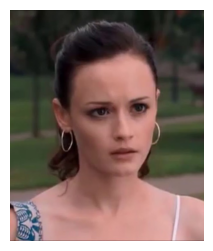

In [8]:
img = cv2.imread(train_files[0])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

## 1.4 Checking balanced Dataset

In [9]:
def load_as_dataframe(path, target_shape=(224, 224)):
    data = load_files(path)
    face_files = np.array(data['filenames'])
    face_targets = np.array(data['target'])

    images, labels = [], []
    for file, target in zip(face_files, face_targets):
        img = cv2.imread(file)
        if img is not None:
            img_resized = cv2.resize(img, target_shape)
            images.append(img_resized)
            labels.append(target)
        else:
            print(f"Failed to load image at path: {file}")

    df = pd.DataFrame({
        'images': images,
        'faceshape': labels
    })

    return df

In [10]:
df_train = load_as_dataframe(train_dir)
df_test = load_as_dataframe(test_dir)

In [11]:
df_train.groupby('faceshape').count()

images
faceshape        
0             799
1             796
2             800
3             800
4             798

In [12]:
df_test.groupby('faceshape').count()

images
faceshape        
0             200
1             200
2             200
3             200
4             200

In [13]:
# Prepare data for SMOTE
X_images = np.array(df_train['images'].tolist()).reshape(len(df_train), -1)
y_matched = df_train['faceshape'].values

In [ ]:
X_images_test = np.array(df_test['images'].tolist()).reshape(len(df_test), -1)
y_matched_test = df_test['faceshape'].values

In [14]:
from PIL import Image

def resize_image(input_image_path, output_image_path, target_size):
    """
    Resize an image to the target size while maintaining its original aspect ratio.
    """
    # Open the image
    img = Image.open(input_image_path)

    # Compute the aspect ratio
    aspect_ratio = img.width / img.height

    # Determine the new width and height
    if aspect_ratio > 1:  # Width is greater than height
        new_width = target_size
        new_height = int(target_size / aspect_ratio)
    else:
        new_height = target_size
        new_width = int(target_size * aspect_ratio)

    # Resize the image
    img = img.resize((new_width, new_height), Image.LANCZOS)

    # Create a new image with a white background and paste the resized image onto it
    new_img = Image.new("RGB", (target_size, target_size), (255, 255, 255))
    y_offset = (target_size - new_height) // 2
    x_offset = (target_size - new_width) // 2
    new_img.paste(img, (x_offset, y_offset))

    # Save the image to the specified output path
    new_img.save(output_image_path)

In [21]:
# 1. Load and Resize Images
images_resized = []
labels = []
input_directory = "FaceShape Dataset/training_set/"  # This is where your original data is
augmented_directory = "augmented_data/training_set"
original_shape= (224, 224, 3)

if not os.path.exists(augmented_directory):
    os.makedirs(augmented_directory)

for folder in os.listdir(input_directory):
    # Create corresponding class folders in the augmented_directory
    os.makedirs(os.path.join(augmented_directory, folder), exist_ok=True)

    for image_path in os.listdir(os.path.join(input_directory, folder)):
        # Resize and maintain aspect ratio
        output_path = os.path.join(augmented_directory, folder, image_path)
        resize_image(os.path.join(input_directory, folder, image_path), output_path, 224)

        # Load the resized image and append to the list
        img = Image.open(output_path)
        images_resized.append(np.array(img))
        labels.append(folder)
        os.remove(output_path)

# 2. Prepare Data for SMOTE
X_images = np.array(images_resized).reshape((len(images_resized), -1))
print(X_images.shape)
y_matched = labels

# 3. Apply SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_images, y_matched)

# 4. Reshape and Save Augmented Images
for idx, (img_array, label) in enumerate(zip(X_res, y_res)):
    img_array_reshaped = img_array.reshape(original_shape)
    # img_array_reshaped = np.clip(img_array_reshaped * 255, 0, 255).astype(np.uint8)
    # img_array_reshaped = img_array_reshaped[..., ::-1]
    img = Image.fromarray(img_array_reshaped)

    filename = os.path.join(augmented_directory, label, f"{label}_{idx}.jpg")

    print(f"Saving image to: {filename}") 

    # Try saving the image
    try:
        img.save(filename)
        print(f"Saved successfully: {filename}") 
    except Exception as e:
        print(f"Error saving image {filename}. Error: {e}")


(3993, 150528)
Saving image to: augmented_data/training_set/Heart/Heart_0.jpg
Saved successfully: augmented_data/training_set/Heart/Heart_0.jpg
Saving image to: augmented_data/training_set/Heart/Heart_1.jpg
Saved successfully: augmented_data/training_set/Heart/Heart_1.jpg
Saving image to: augmented_data/training_set/Heart/Heart_2.jpg
Saved successfully: augmented_data/training_set/Heart/Heart_2.jpg
Saving image to: augmented_data/training_set/Heart/Heart_3.jpg
Saved successfully: augmented_data/training_set/Heart/Heart_3.jpg
Saving image to: augmented_data/training_set/Heart/Heart_4.jpg
Saved successfully: augmented_data/training_set/Heart/Heart_4.jpg
Saving image to: augmented_data/training_set/Heart/Heart_5.jpg
Saved successfully: augmented_data/training_set/Heart/Heart_5.jpg
Saving image to: augmented_data/training_set/Heart/Heart_6.jpg
Saved successfully: augmented_data/training_set/Heart/Heart_6.jpg
Saving image to: augmented_data/training_set/Heart/Heart_7.jpg
Saved successfully:

In [22]:
y_smote_df_train = pd.DataFrame(data=y_res, columns=['faceshape'])
faceshapes_df_train = y_smote_df_train.groupby('faceshape').size().reset_index(name='count')
print(faceshapes_df_train)

  faceshape  count
0     Heart    800
1    Oblong    800
2      Oval    800
3     Round    800
4    Square    800


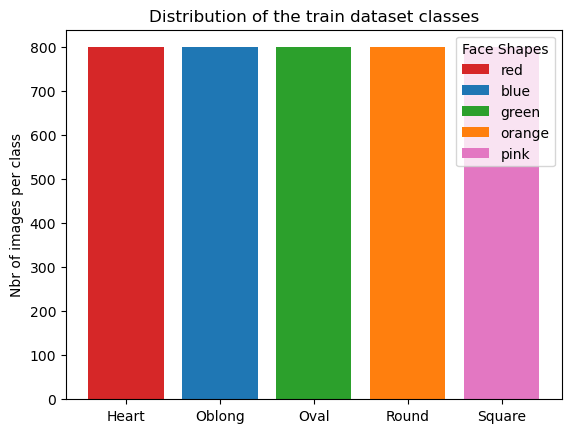

In [24]:
fig, ax = plt.subplots()

bar_labels = ['red', 'blue', 'green', 'orange','pink' ]
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:pink']

ax.bar(faceshapes_df_train['faceshape'], faceshapes_df_train['count'], label=bar_labels, color=bar_colors)

ax.set_ylabel('Nbr of images per class')
ax.set_title('Distribution of the train dataset classes')
ax.legend(title='Face Shapes')

## 1.4 Cleaning corrupted JPEG

In [28]:
train_files, train_targets = load_dataset('augmented_data/testing_set')

In [29]:
from struct import unpack
from tqdm import tqdm
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                break


bads = []

for img in train_files:
    image = JPEG(img)
    try:
        image.decode()
    except:
        bads.append(img)


for name in bads:
    print(name)
    #os.remove(name)

## 1.6 Loading Dataset

In [51]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [95]:
train_dir = 'augmented_data/training_set'
test_dir = 'augmented_data/testing_set'

In [53]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            label_mode= 'categorical',
                                                            validation_split = 0.25,
                                                            subset = "training",
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            seed = 1)



Found 4000 files belonging to 5 classes.
Using 3000 files for training.


In [54]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                          shuffle=True,
                                                          label_mode= 'categorical',
                                                          validation_split = 0.25,
                                                          subset = "validation",
                                                          batch_size=BATCH_SIZE,
                                                          image_size=IMG_SIZE,
                                                          seed = 1)
                                                          

Found 4000 files belonging to 5 classes.
Using 1000 files for validation.


In [96]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           label_mode= 'categorical',
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)
                                                           


Found 1000 files belonging to 5 classes.


## 1.7 Creating Common functions

In [65]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [57]:
def create_model():
  inputs = Input(shape=(224, 224, 3))
  x1 = data_augmentation(inputs)
  x2 = preprocess_input(x1)
  base_model_layer = base_model(x2, training=True)
  pooling_layer = GlobalAveragePooling2D()(base_model_layer)
  dropout_layer = Dropout(0.1)(pooling_layer)
  Layer_1 = Dense(512, activation='relu')(dropout_layer)
  outputs = Dense(5, activation='softmax')(Layer_1)
  model = Model(inputs, outputs)
  return model

## 1.8 Data Preprocessing

In [42]:
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
])

In [43]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
#preprocess_input = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# 2. Model Training

## 2.1 MOBILENETV2 Feature Extraction (train only classification layers / Dense)

In [39]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# setting MobileNetV2 trained weights to untrainable 
base_model.trainable = False

In [40]:
# Display model output shape
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-09-04 02:19:26.204841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3000]
	 [[{{node Placeholder/_4}}]]
2023-09-04 02:19:26.205076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3000]
	 [[{{node Placeholder/_0}}]]


(32, 7, 7, 1280)


In [41]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Create Custom model 

In [42]:
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy',f1_m])

In [ ]:
print("weights:", len(base_model.weights))
print("trainable_weights:", len(base_model.trainable_weights))
print("non_trainable_weights:", len(base_model.non_trainable_weights))

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [44]:
len(model.trainable_variables)

4

### Evaluate model accuracy without training

In [45]:
initial_epochs = 10

loss, accuracy, f1_m0 = model.evaluate(val_dataset)

2023-09-04 02:20:15.455541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-09-04 02:20:15.455765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]


32/32 [==============================] - 9s 255ms/step - loss: 1.6786 - accuracy: 0.2150 - f1_m: 0.0075


In [46]:
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))
print("initial f1 score: {:.2f}".format(f1_m0))

initial loss: 1.68
initial accuracy: 0.22
initial f1 score: 0.01


### Fitting model - 10 epoch

In [47]:
checkpointer_init = ModelCheckpoint(filepath='model1_aug_no_train.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
history_init = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,
                    callbacks = [checkpointer_init],
                    verbose=1)

Epoch 1/10
94/94 [==============================] - ETA: 0s - loss: 1.6573 - accuracy: 0.2820 - f1_m: 0.1188
Epoch 1: val_accuracy improved from -inf to 0.36600, saving model to model1_aug_no_train.hdf5
94/94 [==============================] - 40s 405ms/step - loss: 1.6573 - accuracy: 0.2820 - f1_m: 0.1188 - val_loss: 1.5048 - val_accuracy: 0.3660 - val_f1_m: 0.0440
Epoch 2/10
94/94 [==============================] - ETA: 0s - loss: 1.4468 - accuracy: 0.3690 - f1_m: 0.1423
Epoch 2: val_accuracy improved from 0.36600 to 0.36800, saving model to model1_aug_no_train.hdf5
94/94 [==============================] - 38s 405ms/step - loss: 1.4468 - accuracy: 0.3690 - f1_m: 0.1423 - val_loss: 1.4643 - val_accuracy: 0.3680 - val_f1_m: 0.1366
Epoch 3/10
94/94 [==============================] - ETA: 0s - loss: 1.4145 - accuracy: 0.3897 - f1_m: 0.1910
Epoch 3: val_accuracy improved from 0.36800 to 0.38200, saving model to model1_aug_no_train.hdf5
94/94 [==============================] - 44s 467ms/st

In [48]:
acc = history_init.history['accuracy']
val_acc = history_init.history['val_accuracy']

loss = history_init.history['loss']
val_loss = history_init.history['val_loss']

f1_m = history_init.history['f1_m']
val_f1_m = history_init.history['val_f1_m']

In [50]:
fine_epoch20 = 10
total_epochs =  initial_epochs + fine_epoch20

checkpointer_init_epoch20 = ModelCheckpoint(filepath='Model1_aug_no_train_epoch20.hdf5', verbose=1, monitor='val_accuracy', save_best_only=True)

history_fine_tune = model.fit(train_dataset,
                                   epochs=total_epochs,
                                   initial_epoch=history_init.epoch[-1],
                                   validation_data=val_dataset,
                                   callbacks=[checkpointer_init_epoch20])

Epoch 10/20
94/94 [==============================] - ETA: 0s - loss: 1.1839 - accuracy: 0.5180 - f1_m: 0.4046
Epoch 10: val_accuracy improved from -inf to 0.43500, saving model to Model1_aug_no_train_epoch20.hdf5
94/94 [==============================] - 43s 459ms/step - loss: 1.1839 - accuracy: 0.5180 - f1_m: 0.4046 - val_loss: 1.3723 - val_accuracy: 0.4350 - val_f1_m: 0.2960
Epoch 11/20
94/94 [==============================] - ETA: 0s - loss: 1.1637 - accuracy: 0.5380 - f1_m: 0.4318
Epoch 11: val_accuracy did not improve from 0.43500
94/94 [==============================] - 38s 405ms/step - loss: 1.1637 - accuracy: 0.5380 - f1_m: 0.4318 - val_loss: 1.4703 - val_accuracy: 0.4340 - val_f1_m: 0.3428
Epoch 12/20
94/94 [==============================] - ETA: 0s - loss: 1.1630 - accuracy: 0.5273 - f1_m: 0.4191
Epoch 12: val_accuracy did not improve from 0.43500
94/94 [==============================] - 38s 403ms/step - loss: 1.1630 - accuracy: 0.5273 - f1_m: 0.4191 - val_loss: 1.3889 - val_a

In [51]:
acc_epoch20 = acc + history_fine_tune.history['accuracy']
val_acc_epoch20 = val_acc + history_fine_tune.history['val_accuracy']

loss_epoch20 = loss + history_fine_tune.history['loss']
val_loss_epoch20 = val_loss + history_fine_tune.history['val_loss']

### Displaying Performance measures - 10 epoch

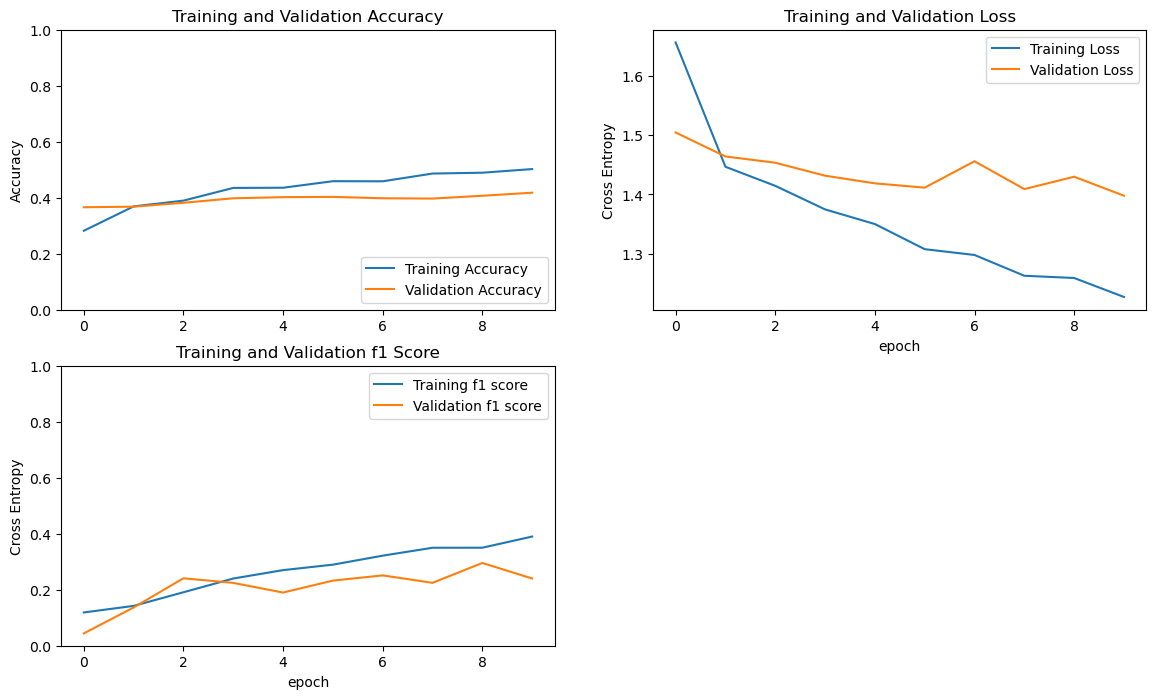

In [49]:
#Model1_aug_no_train - epoch 10 - modified dataset so it balance it and images keep their original ratio size.
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 3)
plt.plot(f1_m, label='Training f1 score')
plt.plot(val_f1_m, label='Validation f1 score')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation f1 Score')
plt.xlabel('epoch')

plt.show()

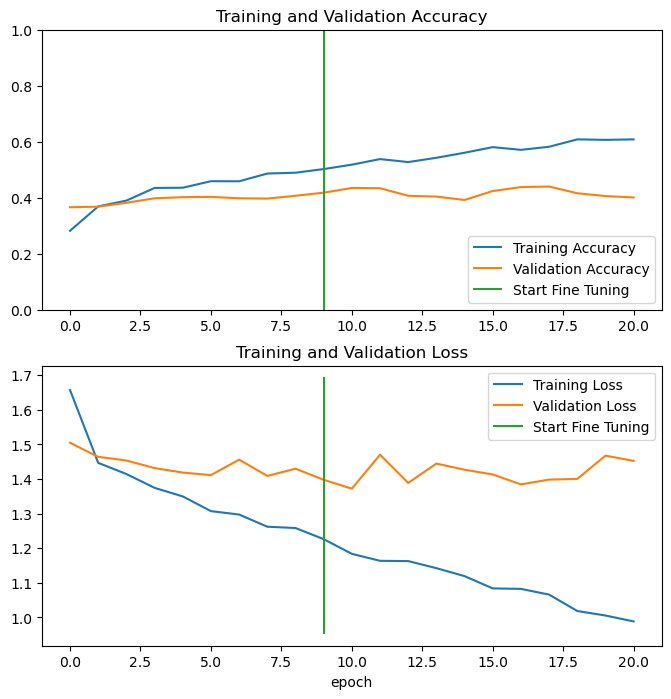

In [54]:
#Model1_aug_no_train - 20 epoch - balance dataset and keep ratio
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_epoch20, label='Training Accuracy')
plt.plot(val_acc_epoch20, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_epoch20, label='Training Loss')
plt.plot(val_loss_epoch20, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [55]:
loss_init, accuracy_init, f1_init = model.evaluate(test_dataset)
print('Test accuracy :', accuracy_init)

2023-09-04 02:42:47.768953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-09-04 02:42:47.769639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]


32/32 [==============================] - 9s 287ms/step - loss: 1.4627 - accuracy: 0.4260 - f1_m: 0.3338
Test accuracy : 0.4259999990463257


In [56]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions[1]

2023-09-04 02:43:07.946647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,224,224,3]
	 [[{{node Placeholder/_0}}]]


array([0.20377606, 0.23453668, 0.14229195, 0.08792582, 0.33146954],
      dtype=float32)

In [58]:
predictions

array([[0.12106752, 0.27851865, 0.1744473 , 0.366103  , 0.05986352],
       [0.20377606, 0.23453668, 0.14229195, 0.08792582, 0.33146954],
       [0.11736572, 0.6249888 , 0.24500829, 0.00140025, 0.01123699],
       [0.1277506 , 0.08493698, 0.62655336, 0.10097859, 0.05978052],
       [0.01220962, 0.0386656 , 0.39733353, 0.29465905, 0.2571322 ],
       [0.02865962, 0.00165962, 0.04903986, 0.91856146, 0.00207949],
       [0.13262789, 0.0698737 , 0.2134814 , 0.29445085, 0.28956616],
       [0.17133947, 0.03117427, 0.13140404, 0.40446052, 0.2616218 ],
       [0.0765238 , 0.09701851, 0.19438702, 0.09448227, 0.5375884 ],
       [0.05787593, 0.45698673, 0.47447693, 0.00522931, 0.00543106],
       [0.08201145, 0.00152672, 0.06607438, 0.7948395 , 0.05554798],
       [0.03392408, 0.24410081, 0.43898553, 0.12795965, 0.15502994],
       [0.02970846, 0.01931248, 0.3346036 , 0.3614166 , 0.2549589 ],
       [0.15904152, 0.4229574 , 0.04264218, 0.1996778 , 0.17568105],
       [0.01884943, 0.02531869, 0.

In [80]:
image_batch

array([[[[2.54000000e+02, 2.54000000e+02, 2.54000000e+02],
         [2.54000000e+02, 2.54000000e+02, 2.54000000e+02],
         [2.54000000e+02, 2.54000000e+02, 2.54000000e+02],
         ...,
         [2.45379395e+02, 2.46379395e+02, 2.41379395e+02],
         [2.47000000e+02, 2.48000000e+02, 2.43000000e+02],
         [2.47000000e+02, 2.48000000e+02, 2.43000000e+02]],

        [[2.54000000e+02, 2.54000000e+02, 2.54000000e+02],
         [2.54000000e+02, 2.54000000e+02, 2.54000000e+02],
         [2.54000000e+02, 2.54000000e+02, 2.54000000e+02],
         ...,
         [2.45379395e+02, 2.46379395e+02, 2.41379395e+02],
         [2.47000000e+02, 2.48000000e+02, 2.43000000e+02],
         [2.47000000e+02, 2.48000000e+02, 2.43000000e+02]],

        [[2.54000000e+02, 2.54000000e+02, 2.54000000e+02],
         [2.54000000e+02, 2.54000000e+02, 2.54000000e+02],
         [2.54000000e+02, 2.54000000e+02, 2.54000000e+02],
         ...,
         [2.47000000e+02, 2.48000000e+02, 2.43000000e+02],
         [

In [124]:
# Apply a softmax since our model returns hot-encoded
predictions = tf.where(tf.argmax(predictions), 0, 1)
print('Predictions:\n', predictions.numpy())
print('number of predictions : ', len(predictions))
print('Labels:\n', label_batch)

InvalidArgumentError: cannot compute SelectV2 as input #0(zero-based) was expected to be a bool tensor but is a int64 tensor [Op:SelectV2]

### Display predictions image

2023-09-04 03:02:19.023588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-09-04 03:02:19.024168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]


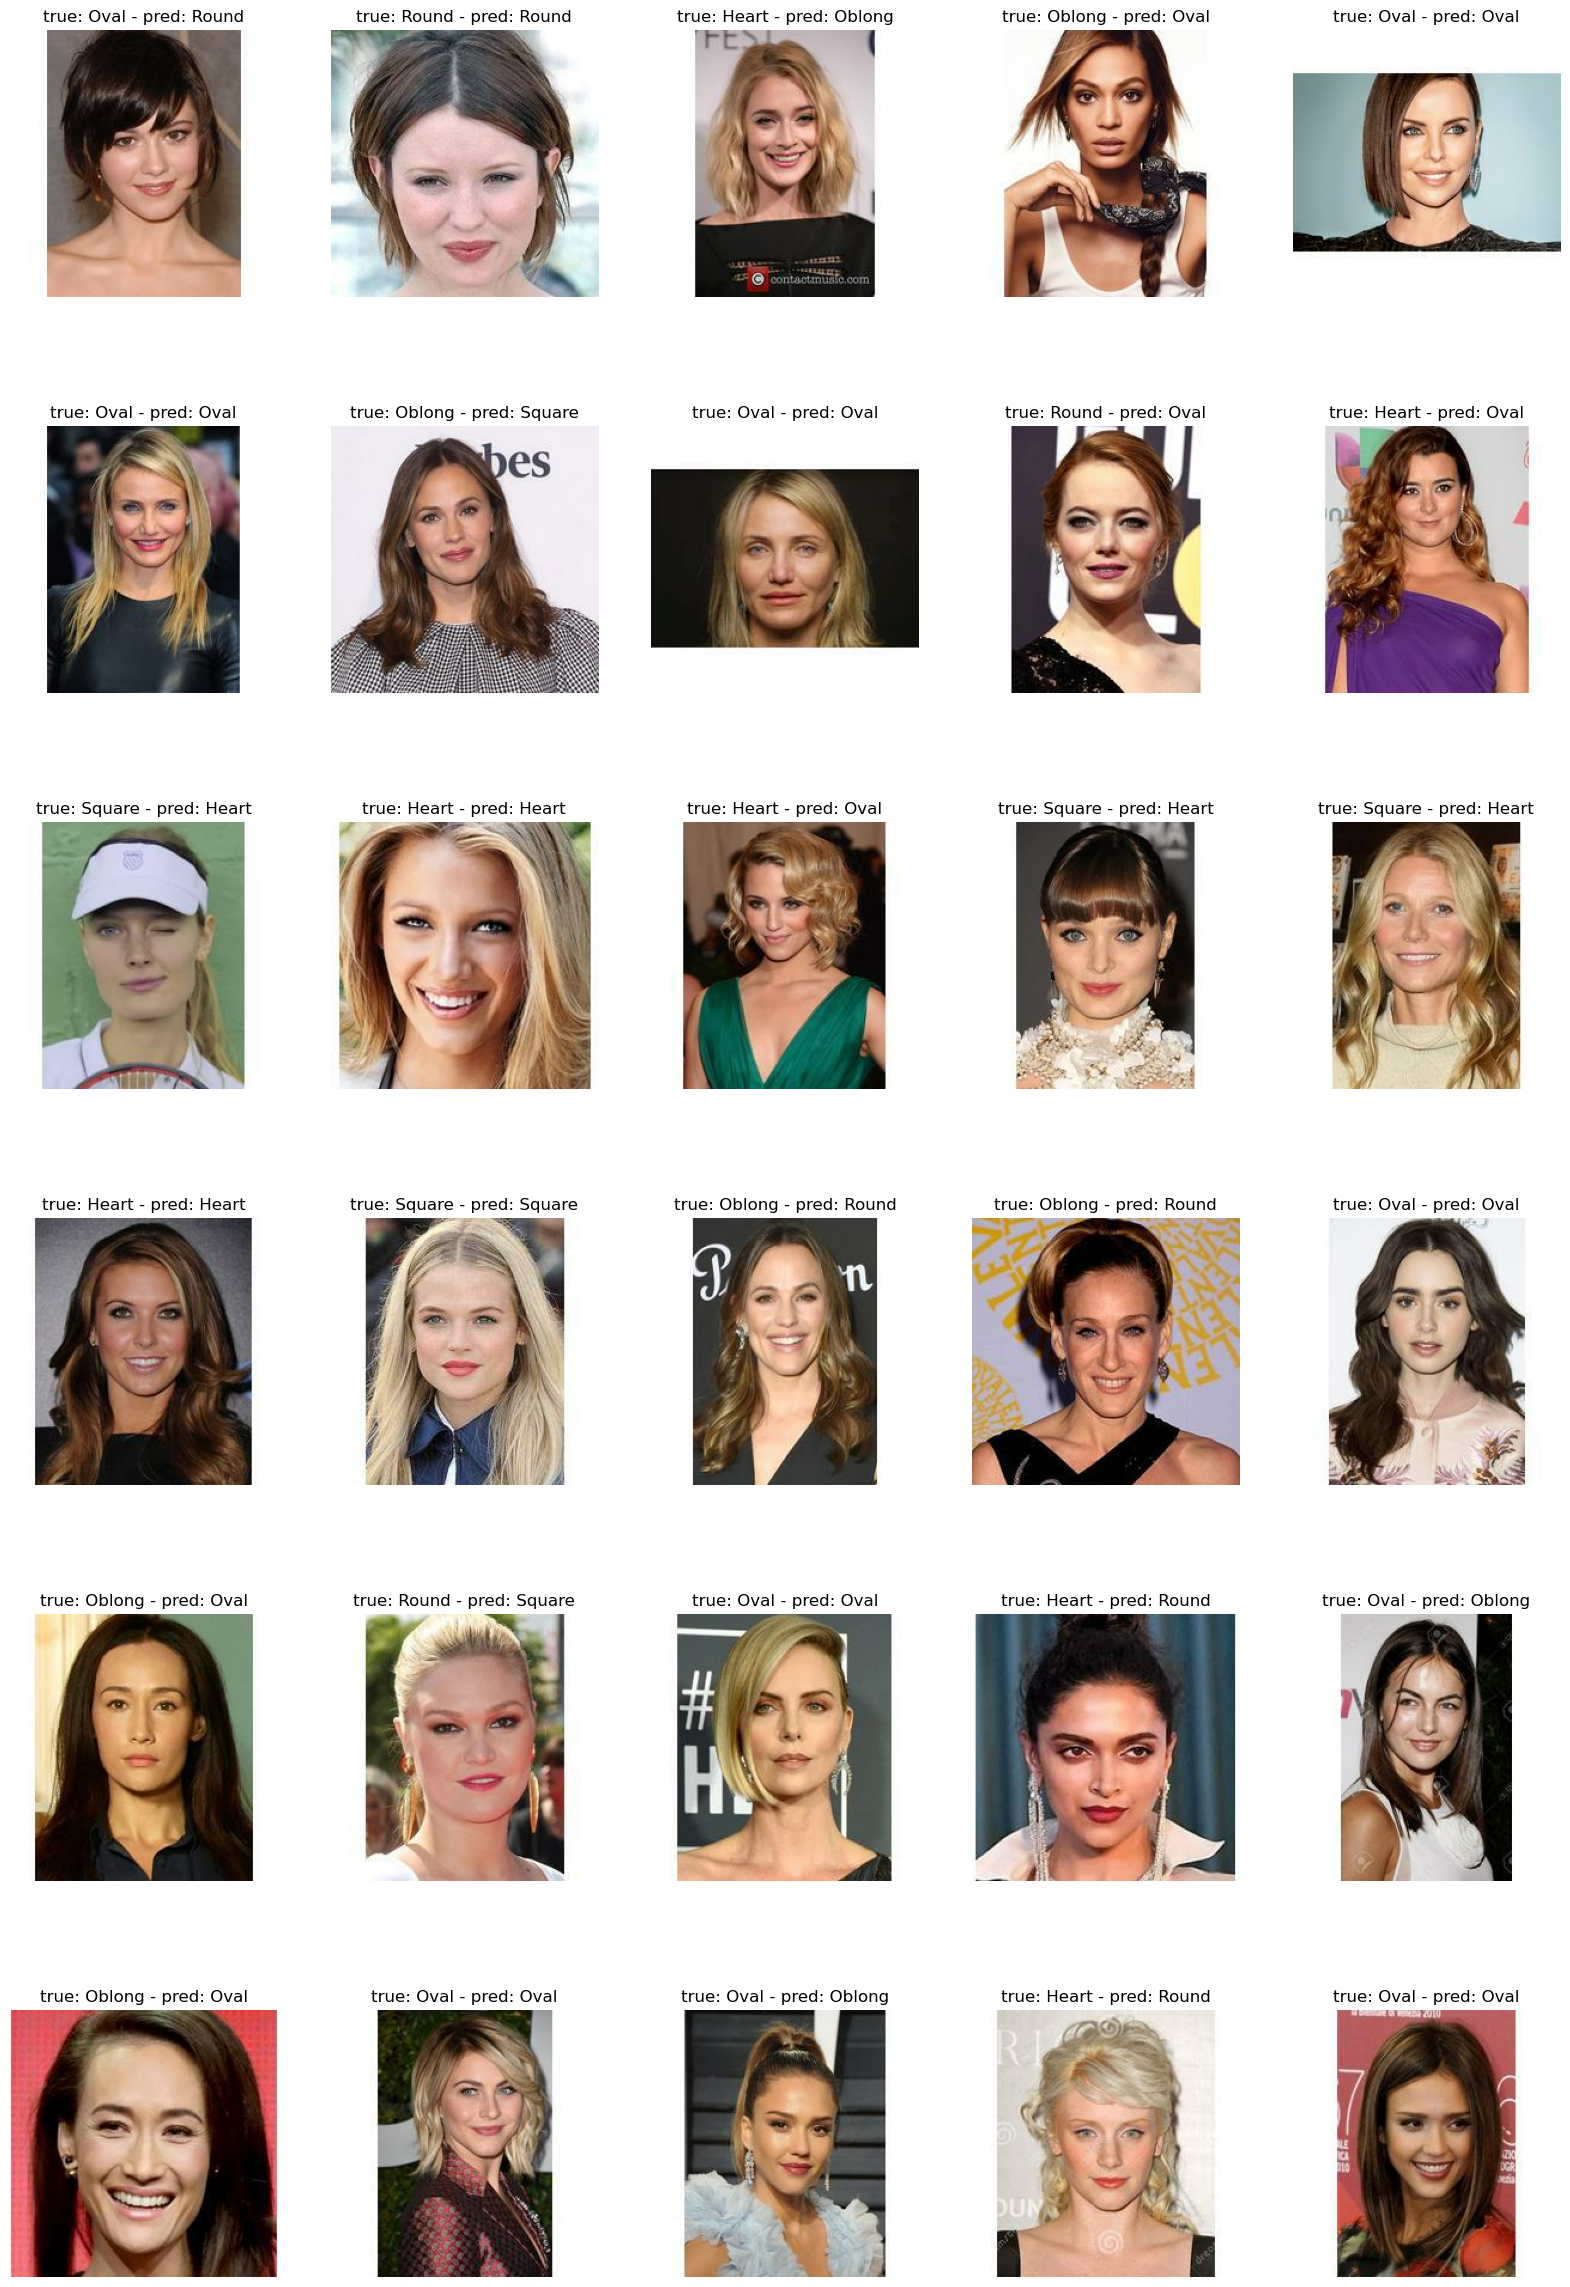

In [78]:
class_names = test_dataset.class_names
plt.figure(figsize=(20,30))
# Grab the first batch of images and labels
for images, labels in test_dataset.take(1):
    for I, (image, label) in enumerate(zip(images, labels)):

        if I >= 30:
            break

        ax = plt.subplot(6, 5, I+1)
        img_init = tf.keras.preprocessing.image.img_to_array(image)
        img = img_init.reshape(1,224,224,3)

        make_prediction = model.predict(img, verbose=0)
        #print(make_prediction)

        predicted_index = tf.argmax(make_prediction, axis=1).numpy()[0]
        predicted_label_name = class_names[predicted_index]

        true_label_name = class_names[label.numpy().tolist().index(1)]

        plt.imshow(img_init.astype("uint8"))
        plt.title(f"true: {true_label_name} - pred: {predicted_label_name}")
        plt.axis("off")

plt.show()

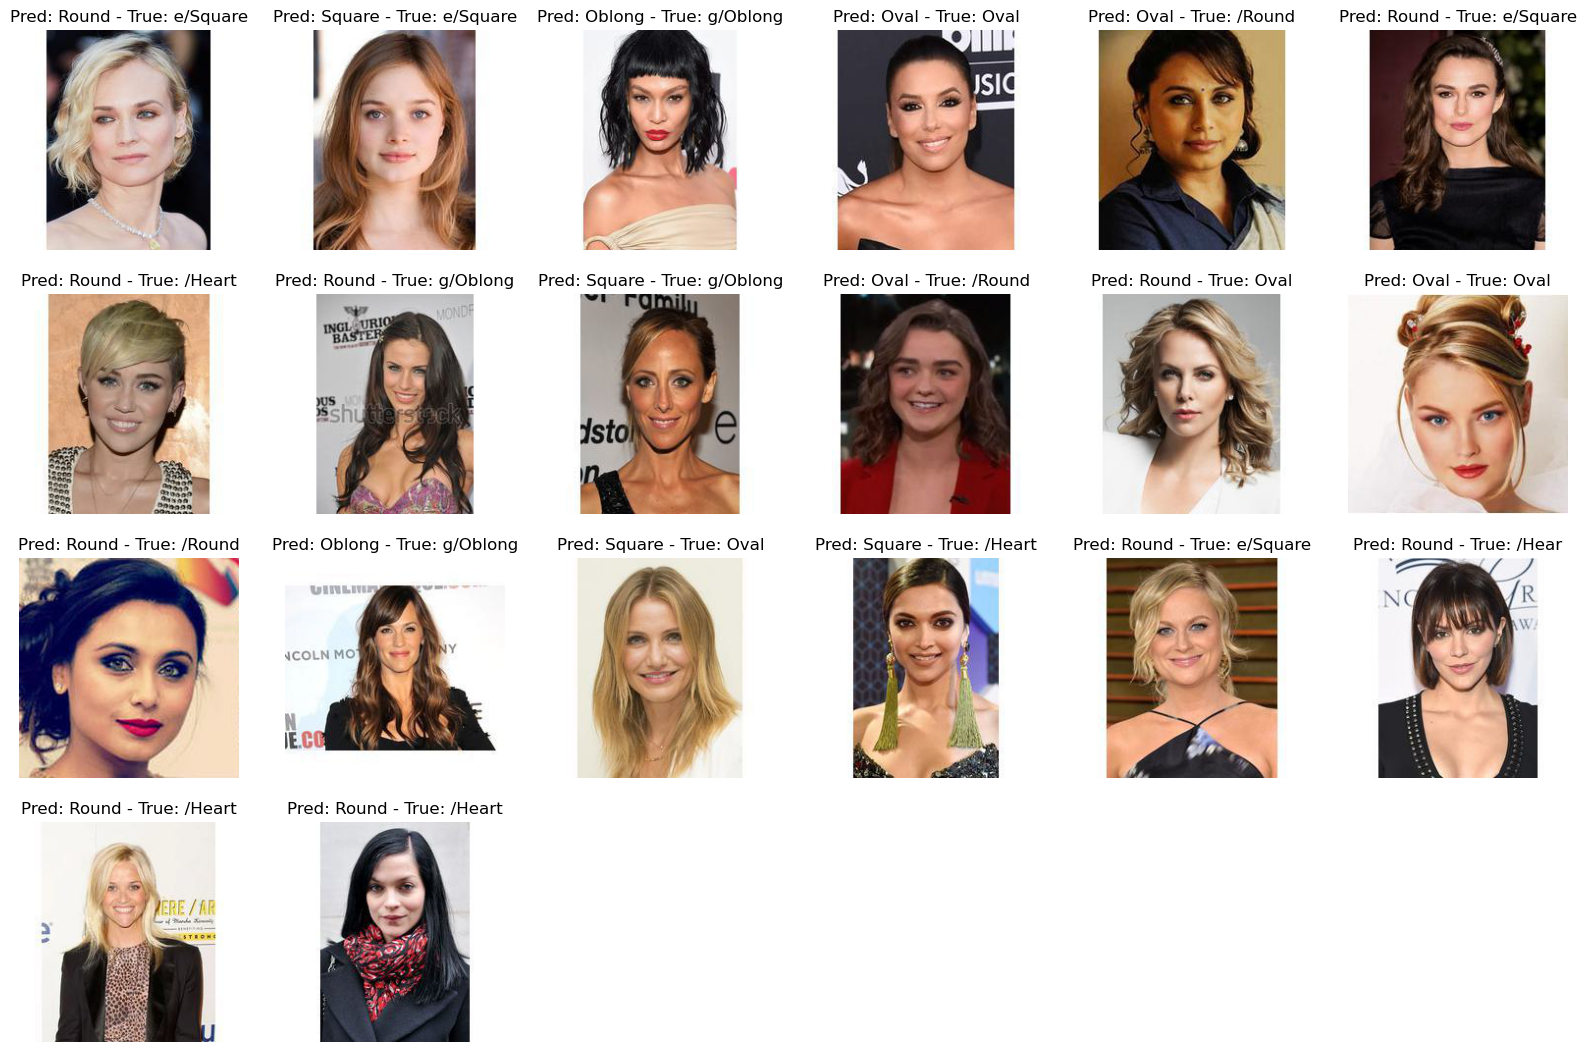

In [79]:
test_files, test_targets = load_dataset(test_dir)
class_names = test_dataset.class_names
plt.figure(figsize=(20,20))
for i in range(20):
    ax = plt.subplot(6, 6, i+1)
    img = cv2.imread(test_files[i])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    face_type = test_files[i][32:-8]
    plt.title(label= f"Pred: {class_names[tf.argmax(predictions[i])]} - True: {face_type}")
    plt.imshow(img_rgb)
    plt.axis('off')

### Confusion Matrix

In [172]:
all_predictions = []
all_labels = []
all_images = []

for batch_data, batch_labels in test_dataset:
    batch_predictions = model.predict(batch_data, verbose=0)
    predicted_labels = np.argmax(batch_predictions, axis=-1)
    all_predictions.extend(predicted_labels)
    true_labels = np.argmax(batch_labels, axis=-1)
    all_labels.extend(true_labels)
    all_images.extend(batch_data)

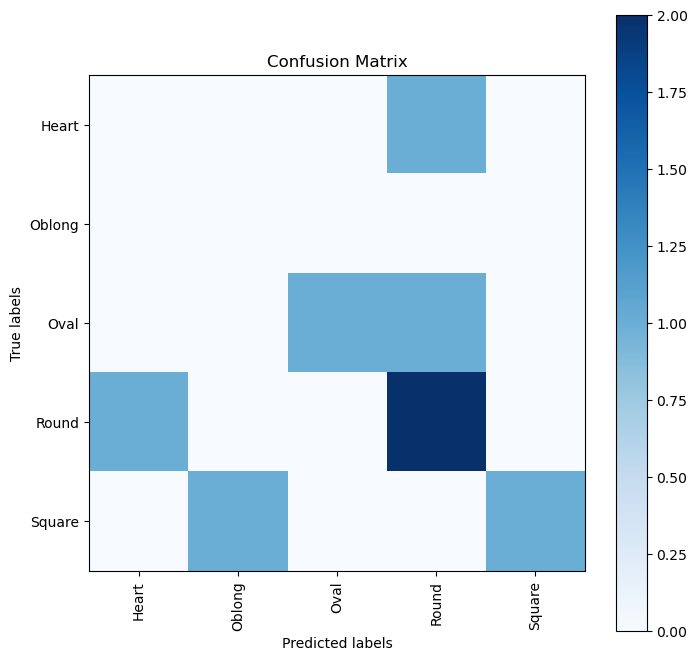

In [72]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(class_names)), class_names, rotation=90)
plt.yticks(np.arange(len(class_names)), class_names)
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

## 2.2 MOBILENETV2 Training (training last convolutional layers + classification layers)

In [58]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [59]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [46]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Create Custom model 

In [64]:
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy',f1_m])

In [61]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [62]:
len(model.trainable_variables)

58

### Fitting model - 10 epoch

In [66]:
initial_epochs = 10
checkpointer_train = ModelCheckpoint(filepath='model3_aug_train_batch32.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
history_train = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,
                    callbacks = [checkpointer_train],
                    verbose=1)

Epoch 1/10
94/94 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.8590 - f1_m: 0.8535
Epoch 1: val_accuracy improved from -inf to 0.71100, saving model to model3_aug_train_batch32.hdf5
94/94 [==============================] - 132s 1s/step - loss: 0.4033 - accuracy: 0.8590 - f1_m: 0.8535 - val_loss: 0.9612 - val_accuracy: 0.7110 - val_f1_m: 0.7136
Epoch 2/10
94/94 [==============================] - ETA: 0s - loss: 0.2441 - accuracy: 0.9170 - f1_m: 0.9184
Epoch 2: val_accuracy improved from 0.71100 to 0.71400, saving model to model3_aug_train_batch32.hdf5
94/94 [==============================] - 121s 1s/step - loss: 0.2441 - accuracy: 0.9170 - f1_m: 0.9184 - val_loss: 1.0550 - val_accuracy: 0.7140 - val_f1_m: 0.7140
Epoch 3/10
94/94 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.9080 - f1_m: 0.9086
Epoch 3: val_accuracy did not improve from 0.71400
94/94 [==============================] - 121s 1s/step - loss: 0.2532 - accuracy: 0.9080 - f1_

In [67]:
acc = history_train.history['accuracy']
val_acc = history_train.history['val_accuracy']

loss = history_train.history['loss']
val_loss = history_train.history['val_loss']

f1_m = history_train.history['f1_m']
val_f1_m = history_train.history['val_f1_m']

### Fitting Model - 20 epoch

In [124]:
fine_epoch20 = 10
total_epochs =  initial_epochs + fine_epoch20

checkpointer_train_epoch20 = ModelCheckpoint(filepath='Model2_aug_train_epoch20.hdf5', verbose=1, monitor='val_accuracy', save_best_only=True)

history_train_epoch20 = model.fit(train_dataset,
                                   epochs=total_epochs,
                                   initial_epoch=history_train.epoch[-1],
                                   validation_data=val_dataset,
                                   callbacks=[checkpointer_train_epoch20])

Epoch 10/20
94/94 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.8470 - f1_m: 0.8433
Epoch 10: val_accuracy improved from -inf to 0.67600, saving model to Model2_aug_train_epoch20.hdf5
94/94 [==============================] - 132s 1s/step - loss: 0.4152 - accuracy: 0.8470 - f1_m: 0.8433 - val_loss: 1.1209 - val_accuracy: 0.6760 - val_f1_m: 0.6781
Epoch 11/20
94/94 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8693 - f1_m: 0.8691
Epoch 11: val_accuracy improved from 0.67600 to 0.70800, saving model to Model2_aug_train_epoch20.hdf5
94/94 [==============================] - 134s 1s/step - loss: 0.3640 - accuracy: 0.8693 - f1_m: 0.8691 - val_loss: 1.0165 - val_accuracy: 0.7080 - val_f1_m: 0.7069
Epoch 12/20
94/94 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.8823 - f1_m: 0.8804
Epoch 12: val_accuracy improved from 0.70800 to 0.70900, saving model to Model2_aug_train_epoch20.hdf5
94/94 [=============================

In [125]:
acc_epoch20 = acc + history_train_epoch20.history['accuracy']
val_acc_epoch20 = val_acc + history_train_epoch20.history['val_accuracy']

loss_epoch20 = loss + history_train_epoch20.history['loss']
val_loss_epoch20 = val_loss + history_train_epoch20.history['val_loss']

f1_m_epoch20 = f1_m + history_train_epoch20.history['f1_m']
val_f1_m_epoch20 = val_f1_m + history_train_epoch20.history['val_f1_m']

### Displaying Performance measures - 10 epoch

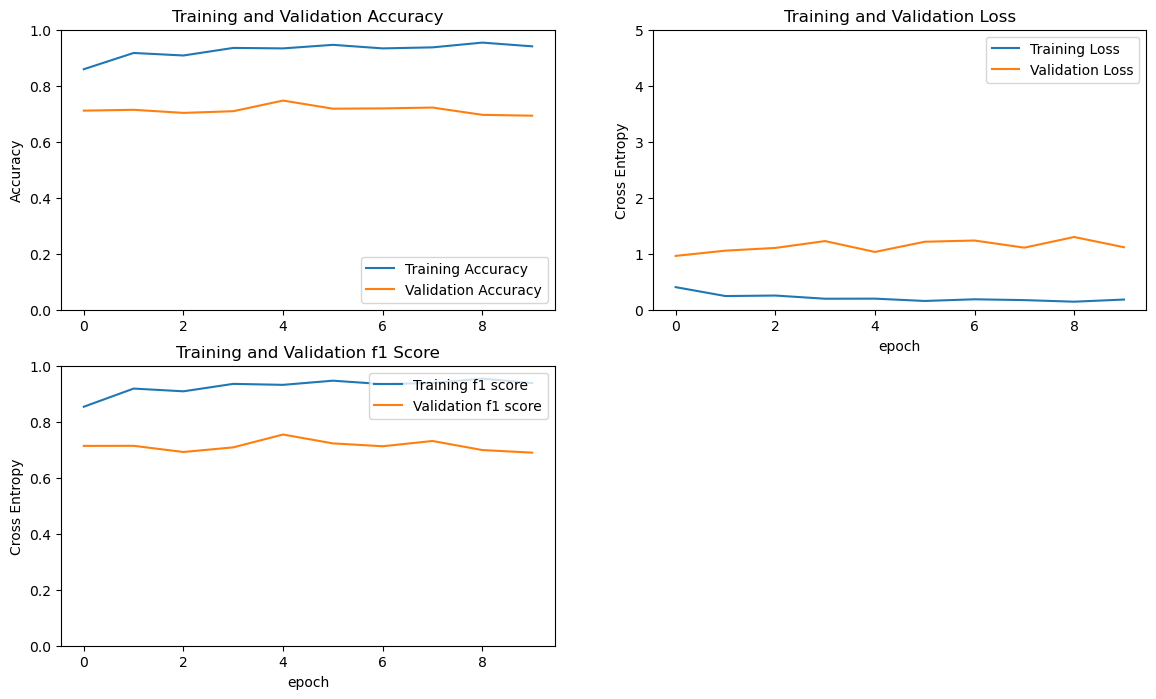

In [68]:
#Model3_aug_train - learning rate 0.0005 - batch 32
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 3)
plt.plot(f1_m, label='Training f1 score')
plt.plot(val_f1_m, label='Validation f1 score')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.])
plt.title('Training and Validation f1 Score')
plt.xlabel('epoch')

plt.show()

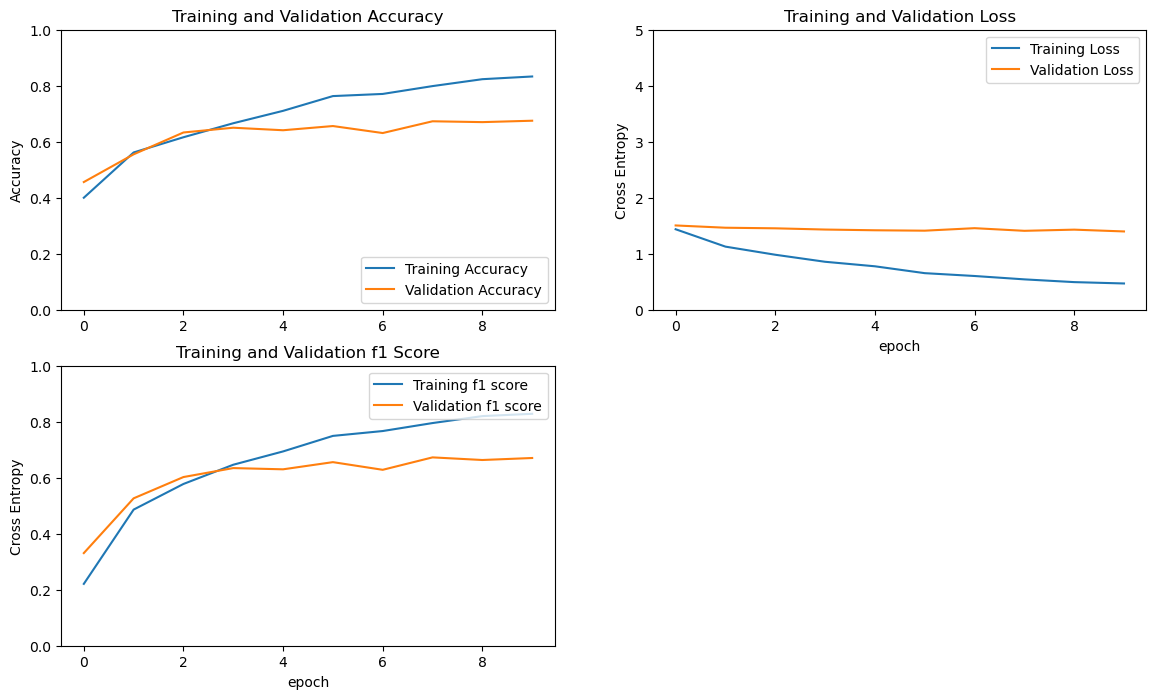

In [123]:
#Model2_aug_train_0.675 - epoch 10 - Trained 50 last layers 

### Diplay Performance measure - 20 epoch

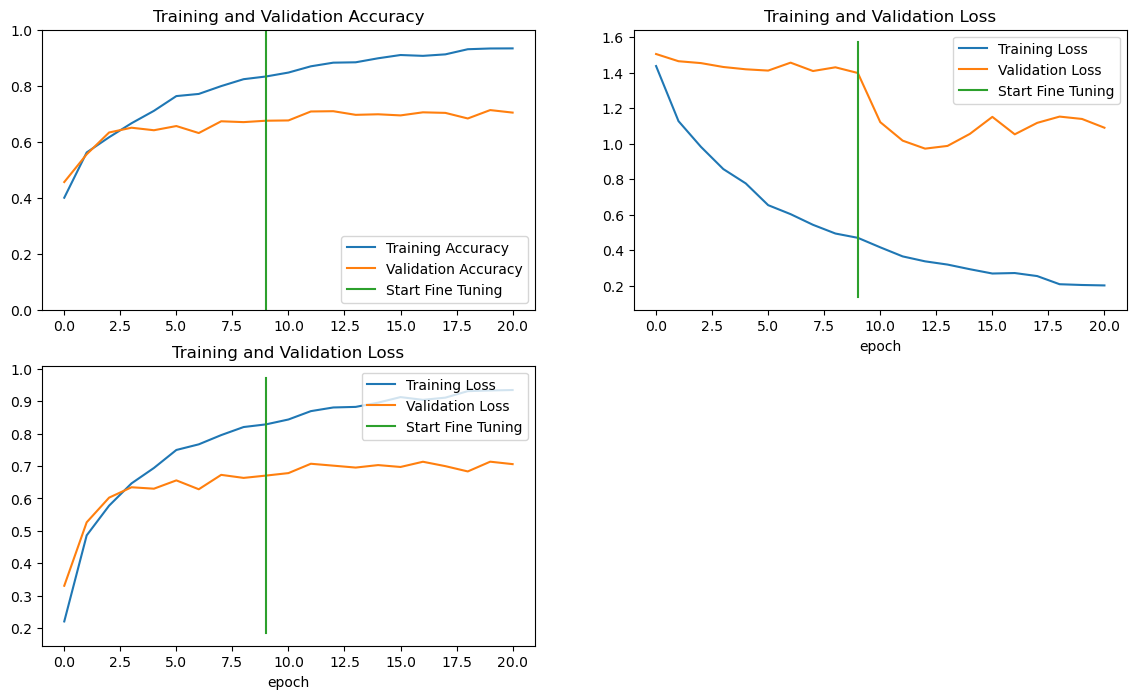

In [133]:
#Model2_aug_train_0.713 - 20 epoch - balance dataset and keep ratio
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(acc_epoch20, label='Training Accuracy')
plt.plot(val_acc_epoch20, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss_epoch20, label='Training Loss')
plt.plot(val_loss_epoch20, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 3)
plt.plot(f1_m_epoch20, label='Training Loss')
plt.plot(val_f1_m_epoch20, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

In [97]:
loss_train, accuracy_train, f1_train = model.evaluate(test_dataset)
print('Test accuracy :', accuracy_train)

2023-09-05 20:29:35.199019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1000]
	 [[{{node Placeholder/_4}}]]
2023-09-05 20:29:35.199673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 23s 702ms/step - loss: 1.1500 - accuracy: 0.6850 - f1_m: 0.6814
Test accuracy : 0.6850000023841858


### Confusion Matrix

In [ ]:
all_predictions = []
all_labels = []
all_images = []

for batch_data, batch_labels in test_dataset:
    batch_predictions = model.predict(batch_data, verbose=0)
    predicted_labels = np.argmax(batch_predictions, axis=-1)
    all_predictions.extend(predicted_labels)
    true_labels = np.argmax(batch_labels, axis=-1)
    all_labels.extend(true_labels)
    all_images.extend(batch_data)

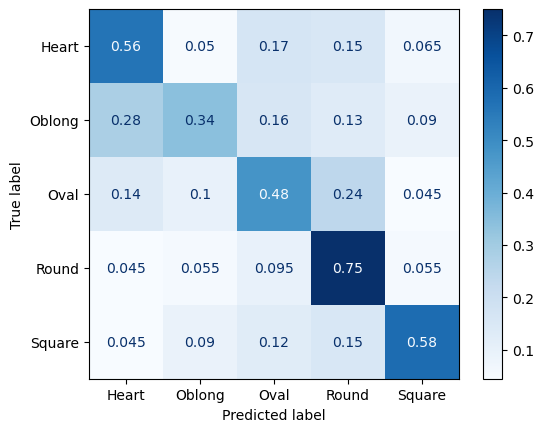

In [90]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = test_dataset.class_names

cm = confusion_matrix(all_labels, all_predictions, normalize= 'true')
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names, )
cmd.plot(cmap=plt.cm.Blues)

### Display predictions image

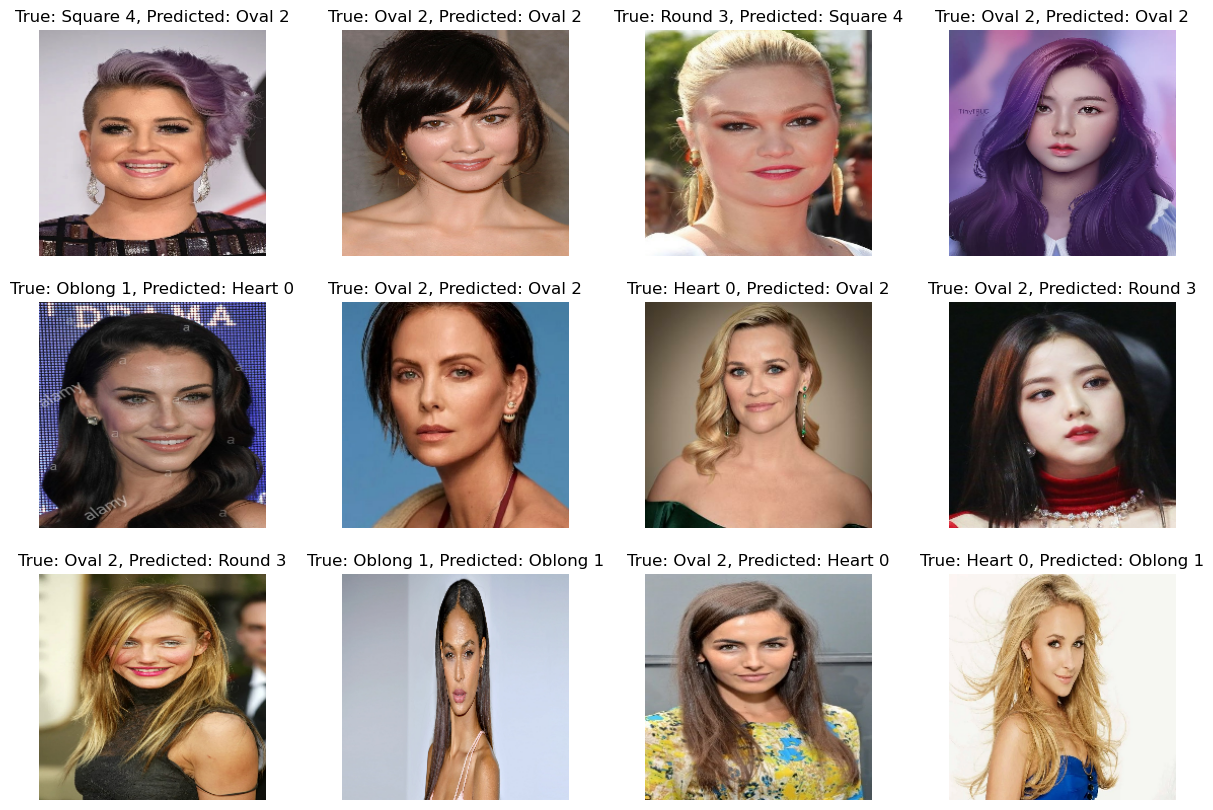

In [93]:
import random

plt.figure(figsize=(15,10))
indices = random.sample(range(len(all_labels)), 12)
class_names = ["Heart", "Oblong", "Oval", "Round", "Square"]
for I,idx in enumerate(indices):
    ax = plt.subplot(3, 4, I+1)
    # Fetch image, true label, and predicted label using the index
    image = all_images[idx].numpy()
    image_int = image.astype(np.uint8)

    true_label_1 = all_labels[idx]
    predicted_label_1 = all_predictions[idx]
    true_label_2 = class_names[all_labels[idx]]
    predicted_label_2 = class_names[all_predictions[idx]]

    # Display
    plt.imshow(image_int)
    plt.title(f"True: {true_label_2} {true_label_1}, Predicted: {predicted_label_2} {predicted_label_1}")
    plt.axis('off')
plt.show()

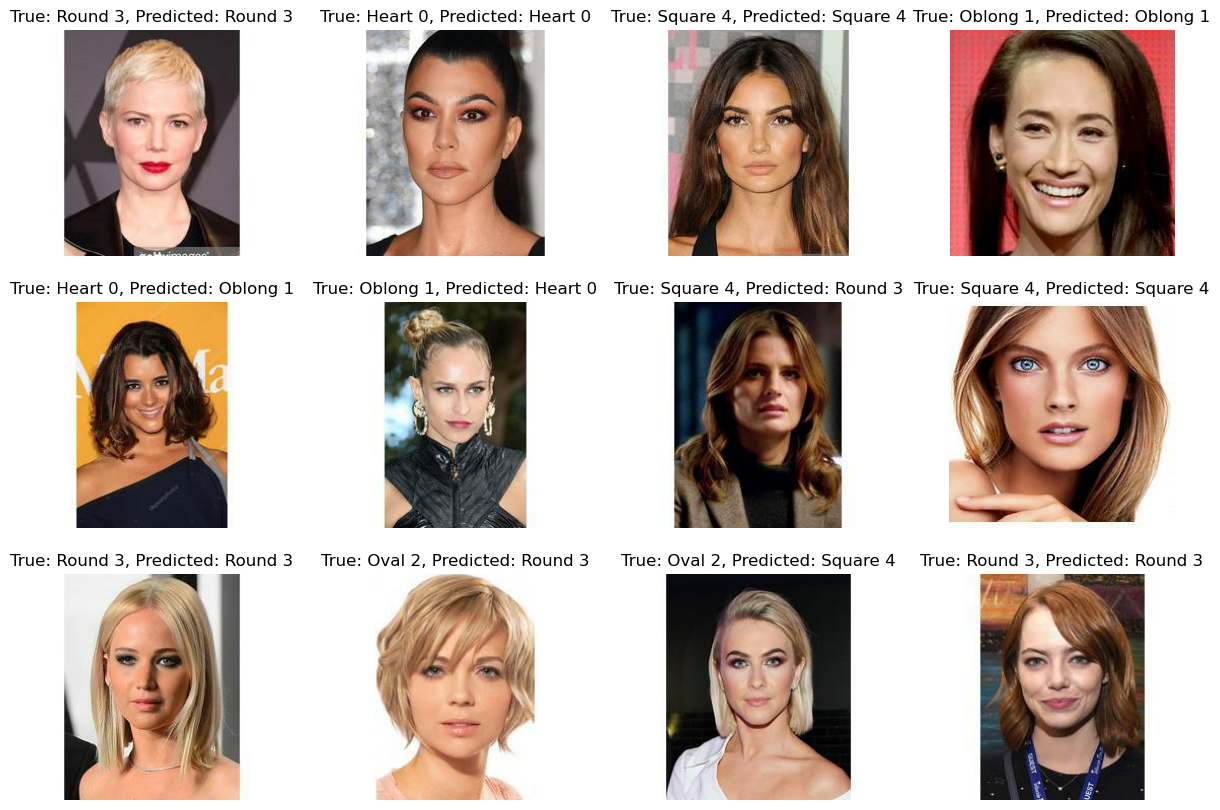

In [197]:
import random

plt.figure(figsize=(15,10))
indices = random.sample(range(len(all_labels)), 12)
class_names = ["Heart", "Oblong", "Oval", "Round", "Square"]
for I,idx in enumerate(indices):
    ax = plt.subplot(3, 4, I+1)
    # Fetch image, true label, and predicted label using the index
    image = all_images[idx].numpy()
    image_int = image.astype(np.uint8)

    true_label_1 = all_labels[idx]
    predicted_label_1 = all_predictions[idx]
    true_label_2 = class_names[all_labels[idx]]
    predicted_label_2 = class_names[all_predictions[idx]]

    # Display
    plt.imshow(image_int)
    plt.title(f"True: {true_label_2} {true_label_1}, Predicted: {predicted_label_2} {predicted_label_1}")
    plt.axis('off')
plt.show()

# 3. FaceShape Predictor Class

In [ ]:
class FaceShapePredictor():


    def __init__(self, img_shape, name, mode):
        self.name = name
        self.img_shape = img_shape + (3,)
        self.mode = mode
        self.class_names =  ['Heart', 'Oblong', 'Oval', 'Round', 'Square']
        self.model = self._build(self.mode)

    def _f1_m(self, y_true, y_pred):
        precision = self._precision_m(y_true, y_pred)
        recall = self._recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

    def _data_augmentation(self,inputs):
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ])
        return data_augmentation(inputs)

    def add_aug_layer(self, layer):
        self._data_augmentation().add(layer)


    def _preprocess_input(self, name, data):
        if name == 'MobileNetV2':
            return tf.keras.applications.mobilenet_v2.preprocess_input(data)
        if name == 'ResNet50':
            return tf.keras.applications.resnet50.preprocess_input(data)
        else:
            print(f"The model {name} is not yet registered in this class")


    def _load_model(self):
        if self.name == 'MobileNetV2':
            return tf.keras.applications.MobileNetV2(input_shape=self.img_shape, include_top=False, weights='imagenet')
        if self.name == 'ResNet50':
            return tf.keras.applications.ResNet50(input_shape=self.img_shape, include_top=False, weights='imagenet')
        else:
            print(f'The model {self.name} you trying to load is not registered')

    def _build(self, mode):
        base_model = self._load_model()
        base_model.trainable = mode
        inputs = Input(shape=self.img_shape)
        x1 = self._data_augmentation(inputs)
        x2 = self._preprocess_input(self.name,x1)
        base_model_layer = base_model(x2, training=mode)
        pooling_layer = GlobalAveragePooling2D()(base_model_layer)
        dropout_layer = Dropout(0.1)(pooling_layer)
        Layer_1 = Dense(512, activation='relu')(dropout_layer)
        outputs = Dense(5, activation='softmax')(Layer_1)
        model = tf.keras.Model(inputs, outputs)


        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy', self._f1_m])

        model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNN_mobileNetV2_model_finetune.hdf5')

        return model


    def predict_breed(self, img_path):
        print('Dog to be identified : ')
        print('Predicting the dog breed ... ')

        img_test = Image.open(img_path)
        display(img_test)
        img_array = np.array(img_test)
        res_img = cv.resize(img_array, (224,224), interpolation=cv.INTER_LINEAR)
        image = np.expand_dims(res_img, axis=0)
        result = self.model.predict(image)
        print('Dog breed predicted : ', self.class_names[np.argmax(result)])
        return self.class_names[np.argmax(result)]